Using device: cuda
dat shape (neurons x trials): (39209, 5900)

=== Running PCA pipeline ===
PCA: 15 components explain ≥90% variance.


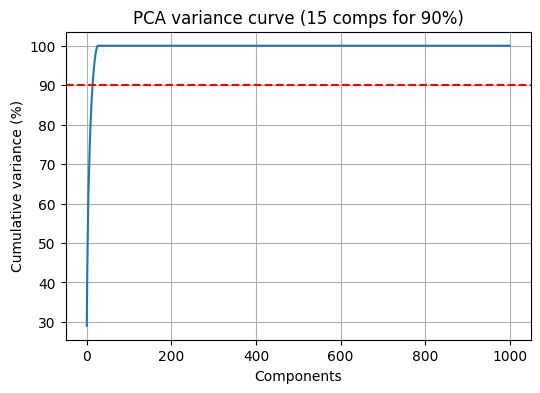

PCA: 2 / 500 significant neurons

=== Running SAE pipeline ===
Epoch  10/60 | loss=0.08853
Epoch  20/60 | loss=0.01706
Epoch  30/60 | loss=0.00572
Epoch  40/60 | loss=0.00281
Epoch  50/60 | loss=0.00199
Epoch  60/60 | loss=0.00194
SAE latent shapes: train (4500, 100), test (1400, 100)
SAE: 1 / 500 significant neurons


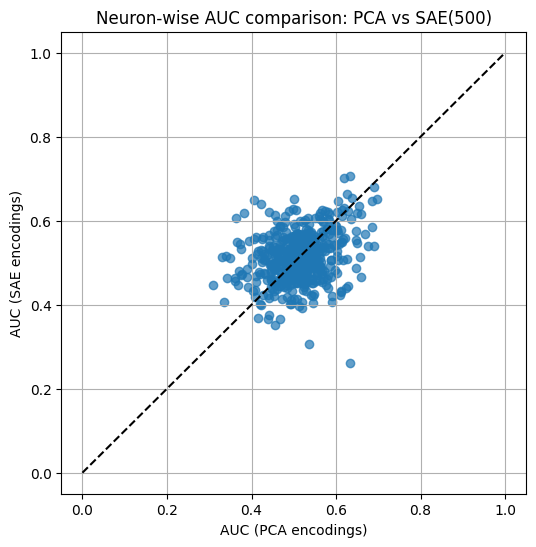


Correlation between PCA and SAE AUCs: r = 0.295


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from skbio.stats.composition import clr
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from sklearn.exceptions import ConvergenceWarning
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle, warnings, torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ================================================================
#  Setup
# ================================================================
warnings.filterwarnings("ignore", category=ConvergenceWarning)
rng = np.random.default_rng(42)
torch.manual_seed(42)
np.random.seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
#  Helper functions
# ---------------------------------------------------------------
def fisher_information_from_logreg(model, X):
    p = model.predict_proba(X)[:, 1]
    W = np.diag(p * (1 - p))
    return X.T @ W @ X / len(X)

def classifier_advantage(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    return auc, 2 * (auc - 0.5)

def hoeffding_pvalue(auc, m, n):
    delta = max(auc - 0.5, 0)
    if delta <= 0 or m == 0 or n == 0:
        return 1.0
    exponent = -2 * delta**2 / (1/m + 1/n)
    return float(np.exp(exponent))

# ---------------------------------------------------------------
#  Load data once
# ---------------------------------------------------------------
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print("dat shape (neurons x trials):", dat.shape)

path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

embeddings = np.stack(list(vit_dict))          # (118, 1000)
X = softmax(embeddings, axis=1)                # convert to probabilities

# ---------------------------------------------------------------
#  Trial structure
# ---------------------------------------------------------------
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)
train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)

# ---------------------------------------------------------------
#  CLR features
# ---------------------------------------------------------------
Y_binary = (dat > 0).astype(int)
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

# ================================================================
#  --- PCA pipeline ---
# ================================================================
print("\n=== Running PCA pipeline ===")
pca_full = PCA()
pca_full.fit(X_trials_clr[test_mask])
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
print(f"PCA: {n_components_90} components explain ≥90% variance.")

pca = PCA(n_components=n_components_90)
pca.fit(X_trials_clr[train_mask])
X_train_pca = pca.transform(X_trials_clr[train_mask])
X_test_pca  = pca.transform(X_trials_clr[test_mask])

plt.figure(figsize=(6,4))
plt.plot(cum_var*100)
plt.axhline(90, color='r', linestyle='--')
plt.xlabel('Components'); plt.ylabel('Cumulative variance (%)')
plt.title(f'PCA variance curve ({n_components_90} comps for 90%)')
plt.grid(True); plt.show()

# ---------------------------------------------------------------
#  Per-neuron logistic regressions (PCA)
# ---------------------------------------------------------------
sampled_neurons = rng.choice(np.arange(n_neurons), size=500, replace=False)
results_pca = []

for idx in sampled_neurons:
    y = Y_binary[idx]
    if y.sum() < 10 or y.sum() > len(y) - 10:
        continue
    y_train, y_test = y[train_mask], y[test_mask]

    model = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', solver='liblinear')
    try:
        model.fit(X_train_pca, y_train)
    except Exception:
        continue

    y_prob = model.predict_proba(X_test_pca)[:, 1]
    auc, adv = classifier_advantage(y_test, y_prob)
    I = fisher_information_from_logreg(model, X_train_pca)
    w = model.coef_.ravel()
    FI_trace, FI_along_w = np.trace(I), float(w @ I @ w)
    EffectiveFI = FI_along_w * (2 * auc - 1)
    m_pos, n_neg = y_test.sum(), len(y_test) - y_test.sum()
    p_val = hoeffding_pvalue(auc, m_pos, n_neg)

    results_pca.append({
        "neuron_idx": idx, "AUC": auc, "Advantage": adv,
        "FI_trace": FI_trace, "FI_along_w": FI_along_w,
        "EffectiveFI": EffectiveFI, "p_value": p_val
    })

df_pca = pd.DataFrame(results_pca)
reject, pvals_corrected, _, _ = multipletests(df_pca["p_value"], alpha=0.05, method="fdr_bh")
df_pca["p_adj"], df_pca["significant"] = pvals_corrected, reject
print(f"PCA: {df_pca['significant'].sum()} / {len(df_pca)} significant neurons")

# ================================================================
#  --- SAE pipeline ---
# ================================================================
print("\n=== Running SAE pipeline ===")
SAE_DIM, SAE_EPOCHS, SAE_BATCH, SAE_LR, SAE_L1 = 100, 60, 256, 1e-3, 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 124), nn.ReLU(inplace=True),
            nn.Linear(124, d_latent), nn.ReLU(inplace=True)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 124), nn.ReLU(inplace=True),
            nn.Linear(124, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train):
    d_in = X_train.shape[1]
    model = SAE(d_in, SAE_DIM).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=SAE_LR)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=SAE_BATCH, shuffle=True)
    for ep in range(1, SAE_EPOCHS+1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(DEVICE)
            xhat, h = model(xb)
            loss = mse(xhat, xb) + SAE_L1 * torch.mean(torch.abs(h))
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item()*xb.size(0)
        if ep % 10 == 0 or ep == SAE_EPOCHS:
            print(f"Epoch {ep:3d}/{SAE_EPOCHS} | loss={tot/len(dl.dataset):.5f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

X_train_clr = X_trials_clr[train_mask]
X_test_clr  = X_trials_clr[test_mask]
sae_model, sae_scaler = train_sae(X_train_clr)
Z_train = encode(sae_model, sae_scaler, X_train_clr)
Z_test  = encode(sae_model, sae_scaler, X_test_clr)
print(f"SAE latent shapes: train {Z_train.shape}, test {Z_test.shape}")

# ---------------------------------------------------------------
#  Per-neuron logistic regressions (SAE)
# ---------------------------------------------------------------
results_sae = []
for idx in sampled_neurons:
    y = Y_binary[idx]
    if y.sum() < 10 or y.sum() > len(y) - 10:
        continue
    y_train, y_test = y[train_mask], y[test_mask]

    model = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', solver='liblinear')
    try:
        model.fit(Z_train, y_train)
    except Exception:
        continue

    y_prob = model.predict_proba(Z_test)[:, 1]
    auc, adv = classifier_advantage(y_test, y_prob)
    I = fisher_information_from_logreg(model, Z_train)
    w = model.coef_.ravel()
    FI_trace, FI_along_w = np.trace(I), float(w @ I @ w)
    EffectiveFI = FI_along_w * (2 * auc - 1)
    m_pos, n_neg = y_test.sum(), len(y_test) - y_test.sum()
    p_val = hoeffding_pvalue(auc, m_pos, n_neg)

    results_sae.append({
        "neuron_idx": idx, "AUC": auc, "Advantage": adv,
        "FI_trace": FI_trace, "FI_along_w": FI_along_w,
        "EffectiveFI": EffectiveFI, "p_value": p_val
    })

df_sae = pd.DataFrame(results_sae)
reject, pvals_corrected, _, _ = multipletests(df_sae["p_value"], alpha=0.05, method="fdr_bh")
df_sae["p_adj"], df_sae["significant"] = pvals_corrected, reject
print(f"SAE: {df_sae['significant'].sum()} / {len(df_sae)} significant neurons")

# ================================================================
#  --- Compare PCA vs SAE AUCs ---
# ================================================================
merged = pd.merge(df_pca[["neuron_idx","AUC"]],
                  df_sae[["neuron_idx","AUC"]],
                  on="neuron_idx", suffixes=("_PCA","_SAE"))

plt.figure(figsize=(6,6))
plt.scatter(merged["AUC_PCA"], merged["AUC_SAE"], alpha=0.7)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("AUC (PCA encodings)")
plt.ylabel("AUC (SAE encodings)")
plt.title("Neuron-wise AUC comparison: PCA vs SAE(500)")
plt.grid(True)
plt.show()

r = np.corrcoef(merged["AUC_PCA"], merged["AUC_SAE"])[0,1]
print(f"\nCorrelation between PCA and SAE AUCs: r = {r:.3f}")



=== FI ↔ AUC calibration (all neurons) ===
[PCA (all)] n=500 | Pearson r=0.149, Spearman ρ=0.110, slope(standardized)=0.010, R²=0.022
[SAE (all)] n=500 | Pearson r=0.127, Spearman ρ=0.034, slope(standardized)=0.008, R²=0.016

=== FI ↔ AUC calibration (SAE-better neurons) ===
[SAE (SAE>AUC_PCA)] n=246 | Pearson r=0.155, Spearman ρ=0.041, slope(standardized)=0.008, R²=0.024
[PCA (SAE>AUC_PCA)] n=246 | Pearson r=0.062, Spearman ρ=0.042, slope(standardized)=0.004, R²=0.004

=== 2×2 of ΔAUC vs ΔFI signs ===
sign(ΔFI SAE−PCA)   ΔFI<0  ΔFI>0
sign(ΔAUC SAE−PCA)              
-1.0                    6    248
 1.0                   13    233


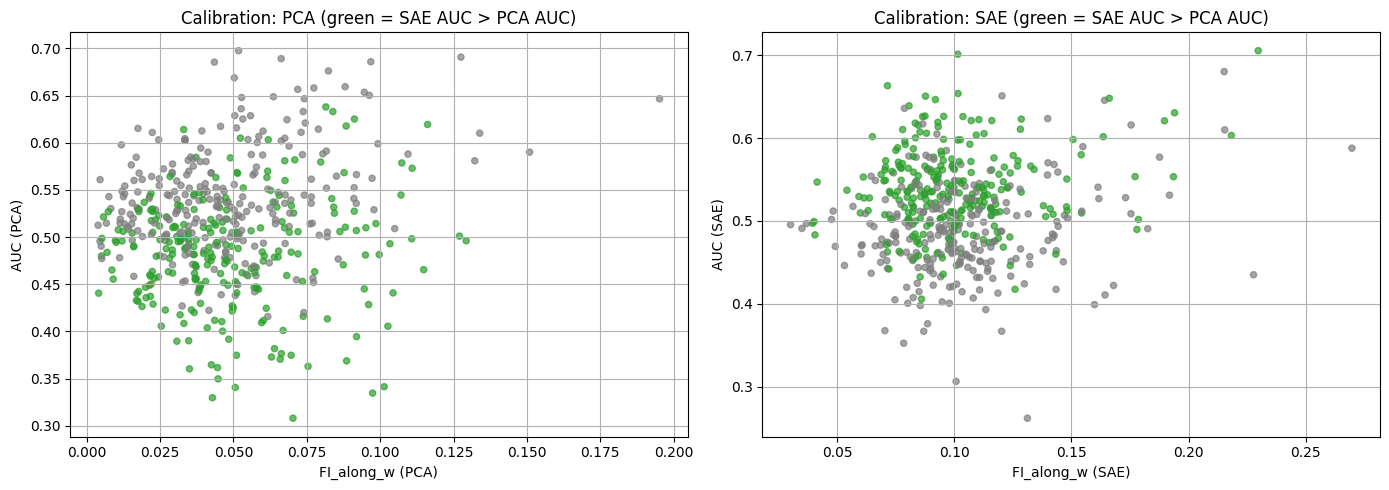

/tmp/ipykernel_366135/1277873103.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby("bin").agg(mean_FI=(fi_col,"mean"), mean_AUC=(auc_col,"mean"),
/tmp/ipykernel_366135/1277873103.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby("bin").agg(mean_FI=(fi_col,"mean"), mean_AUC=(auc_col,"mean"),


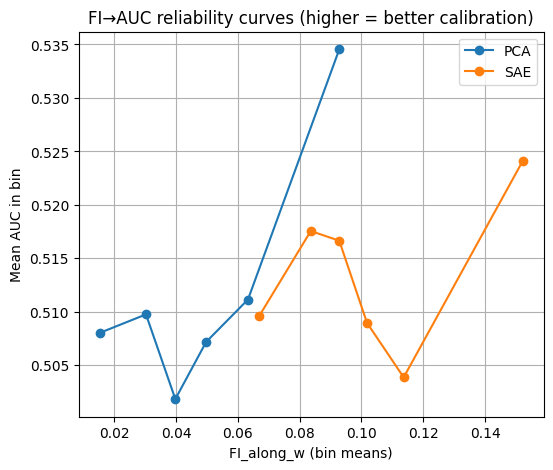

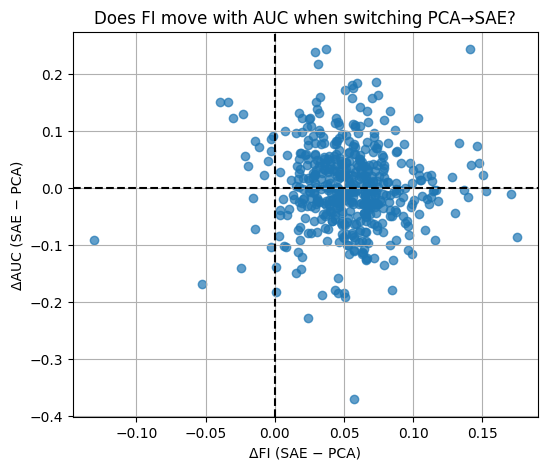


Summary: 246/500 neurons have AUC_SAE > AUC_PCA.
In 239/500 neurons, FI and AUC move in the same direction when switching encoders.


In [5]:
# ============================
# Calibration & improvement analysis (append after previous code)
# ============================
from scipy.stats import pearsonr, spearmanr

# Merge essentials from both pipelines
cal = pd.merge(
    df_pca[["neuron_idx","AUC","FI_along_w"]],
    df_sae[["neuron_idx","AUC","FI_along_w"]],
    on="neuron_idx", suffixes=("_PCA","_SAE")
).dropna()

# Define improvement and deltas
eps = 0.0
cal["SAE_better"] = cal["AUC_SAE"] > cal["AUC_PCA"] + eps
cal["dAUC"] = cal["AUC_SAE"] - cal["AUC_PCA"]
cal["dFI"]  = cal["FI_along_w_SAE"] - cal["FI_along_w_PCA"]

def calibration_stats(df, auc_col, fi_col, label=""):
    if len(df) == 0:
        return np.nan, np.nan, np.nan, np.nan
    r, rp = pearsonr(df[fi_col], df[auc_col])
    s = spearmanr(df[fi_col], df[auc_col]).correlation
    x = (df[fi_col] - df[fi_col].mean()) / (df[fi_col].std() + 1e-12)
    y = df[auc_col]
    beta = float(np.dot(x, y) / (np.dot(x, x) + 1e-12))  # standardized slope
    r2 = r**2
    print(f"[{label}] n={len(df)} | Pearson r={r:.3f}, Spearman ρ={s:.3f}, "
          f"slope(standardized)={beta:.3f}, R²={r2:.3f}")
    return r, s, beta, r2

print("\n=== FI ↔ AUC calibration (all neurons) ===")
calibration_stats(cal, "AUC_PCA", "FI_along_w_PCA", label="PCA (all)")
calibration_stats(cal, "AUC_SAE", "FI_along_w_SAE", label="SAE (all)")

print("\n=== FI ↔ AUC calibration (SAE-better neurons) ===")
calibration_stats(cal[cal["SAE_better"]], "AUC_SAE", "FI_along_w_SAE", label="SAE (SAE>AUC_PCA)")
calibration_stats(cal[cal["SAE_better"]], "AUC_PCA", "FI_along_w_PCA", label="PCA (SAE>AUC_PCA)")

# Did FI increase in the encoder that improved AUC?
improved_counts = pd.crosstab(
    pd.Series(np.sign(cal["dAUC"]), name="sign(ΔAUC SAE−PCA)"),
    pd.Series(np.sign(cal["dFI"]),  name="sign(ΔFI SAE−PCA)")
).rename(columns={-1:"ΔFI<0", 0:"ΔFI≈0", 1:"ΔFI>0"})
print("\n=== 2×2 of ΔAUC vs ΔFI signs ===")
print(improved_counts)

# ---------- Plots ----------
plt.figure(figsize=(14,5))

# (A) FI vs AUC scatter for PCA
plt.subplot(1,2,1)
cmap = np.where(cal["SAE_better"], "tab:green", "tab:gray")
plt.scatter(cal["FI_along_w_PCA"], cal["AUC_PCA"], c=cmap, alpha=0.7, s=20)
plt.xlabel("FI_along_w (PCA)")
plt.ylabel("AUC (PCA)")
plt.title("Calibration: PCA (green = SAE AUC > PCA AUC)")
plt.grid(True)

# (B) FI vs AUC scatter for SAE
plt.subplot(1,2,2)
plt.scatter(cal["FI_along_w_SAE"], cal["AUC_SAE"],
            c=cmap, alpha=0.7, s=20)
plt.xlabel("FI_along_w (SAE)")
plt.ylabel("AUC (SAE)")
plt.title("Calibration: SAE (green = SAE AUC > PCA AUC)")
plt.grid(True)

plt.tight_layout()
plt.show()

# Reliability curves: bin FI and average AUC within bins
def reliability_curve(df, fi_col, auc_col, q=6):
    df = df[[fi_col, auc_col]].dropna().copy()
    df["bin"] = pd.qcut(df[fi_col], q=q, duplicates="drop")
    g = df.groupby("bin").agg(mean_FI=(fi_col,"mean"), mean_AUC=(auc_col,"mean"),
                              n=("bin","size")).reset_index(drop=True)
    return g.sort_values("mean_FI")

g_p = reliability_curve(cal, "FI_along_w_PCA", "AUC_PCA", q=6)
g_s = reliability_curve(cal, "FI_along_w_SAE", "AUC_SAE", q=6)

plt.figure(figsize=(6,5))
plt.plot(g_p["mean_FI"], g_p["mean_AUC"], marker="o", label="PCA")
plt.plot(g_s["mean_FI"], g_s["mean_AUC"], marker="o", label="SAE")
plt.xlabel("FI_along_w (bin means)")
plt.ylabel("Mean AUC in bin")
plt.title("FI→AUC reliability curves (higher = better calibration)")
plt.legend()
plt.grid(True)
plt.show()

# ΔAUC vs ΔFI summary plot
plt.figure(figsize=(6,5))
plt.scatter(cal["dFI"], cal["dAUC"], alpha=0.7)
plt.axhline(0, ls="--", c="k"); plt.axvline(0, ls="--", c="k")
plt.xlabel("ΔFI (SAE − PCA)")
plt.ylabel("ΔAUC (SAE − PCA)")
plt.title("Does FI move with AUC when switching PCA→SAE?")
plt.grid(True)
plt.show()

# Textual summary to help interpretation
n_total = len(cal)
n_sae_better = int(cal["SAE_better"].sum())
co_move = ((np.sign(cal["dAUC"]) == np.sign(cal["dFI"])) & (np.sign(cal["dAUC"]) != 0)).sum()
print(f"\nSummary: {n_sae_better}/{n_total} neurons have AUC_SAE > AUC_PCA.")
print(f"In {co_move}/{n_total} neurons, FI and AUC move in the same direction when switching encoders.")
